In [2]:
#import axion_ppa
import os
os.chdir("../")
import ppa
import numpy as np
import matplotlib.pyplot as plt
import json
import numpy.linalg as nl
import scipy.linalg as sl
import scipy.interpolate as si


import matplotlib as mpl
import matplotlib.pyplot as plt
import glob
import scipy.constants as sc
from astropy.time import Time
from scipy.sparse import bmat


plt.rc('font',**{'family':'serif','serif':['Times']})
mpl.rcParams['font.size'] = 13
#mpl.rcParams['font.family'] = 'serif'
#mpl.rcParams['font.sans-serif'] = ['DejaVu Sans']
mpl.rcParams['axes.linewidth'] = 1
mpl.rcParams['lines.linewidth'] = 2.5
mpl.rcParams['patch.linewidth'] = 1

# Changing this will affect the size of the plot in Jupyter notebook as well as resolution of the final PDF. Can change later
plt.rcParams['figure.dpi'] = 100

# tick parameters:
mpl.rcParams['xtick.top'] = True
mpl.rcParams['ytick.right'] = True


mpl.rcParams['xtick.minor.visible'] = True
mpl.rcParams['ytick.minor.visible'] = True
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['xtick.direction'] = 'in'
    
mpl.rcParams['xtick.major.size'] = 6  # default 3.5
mpl.rcParams['ytick.major.size'] = 6  # default 3.5
mpl.rcParams['xtick.minor.size'] =  3  # default 2 
mpl.rcParams['ytick.minor.size'] = 3  # default 2 
    
mpl.rcParams['xtick.major.width'] = 1  # default 0.8
mpl.rcParams['ytick.major.width'] = 1  # default 0.8
mpl.rcParams['xtick.minor.width'] =1  # default 0.6
mpl.rcParams['ytick.minor.width'] = 1  # default 0.6



PSR_DICT= ppa.Load_All_Pulsar_Info()
PSR_NAME_LIST = list(PSR_DICT.keys())
with open("ppa/Parfile/spa_results.json",'r') as f:
    spa_results = json.load(f)

In [2]:
for i,p in enumerate(PSR_NAME_LIST):
    print(i,p)

0 J0437-4715
1 J0613-0200
2 J0614-3329
3 J0711-6830
4 J1017-7156
5 J1022+1001
6 J1024-0719
7 J1045-4509
8 J1125-6014
9 J1446-4701
10 J1545-4550
11 J1600-3053
12 J1603-7202
13 J1643-1224
14 J1713+0747
15 J1730-2304
16 J1732-5049
17 J1744-1134
18 J1824-2452
19 J1832-0836
20 J1857+0943
21 J1909-3744
22 J1939+2134
23 J2124-3358
24 J2129-5721
25 J2145-0750
26 J2241-5236


In [3]:
order=2
iono='ionfr'
subset="10cm"
pulsars = []
for psrn in PSR_DICT:
    nfreqs_dict_psr = {}
    for key in spa_results[psrn].keys():
        psr_noise = spa_results[psrn][key]
        if psr_noise[4]>2.3 and psr_noise[3]<=-3:
            nfreqs_dict_psr.update( { key : 5 } )
        elif psr_noise[4]>2.3 and psr_noise[3]>=-3:
            nfreqs_dict_psr.update( { key : 30 } )
        else:
            nfreqs_dict_psr.update( { key : 0 } )
    pulsar = ppa.Pulsar(PSR_DICT[psrn],order = order \
                        , iono = iono , subset=subset,nfreqs_dict=nfreqs_dict_psr )
    pulsars.append(pulsar)
    if len(pulsar.FREQS)>0:
        print(psrn,len(pulsar.FREQS[0]) )
    

array = ppa.Array(pulsars)
lnlike0 = array.Generate_Lnlike_Function("none")
lnlike1 = array.Generate_Lnlike_Function("auto")
lnlike2 = array.Generate_Lnlike_Function("full")


NPSR = array.NPSR
NSS = array.NSUBSETS_TOTAL
print(NPSR,NSS)


def Mapper(params):

    l10_EFAC = params[:NSS]
    l10_EQUAD = params[NSS:2*NSS]
    l10_S0 = params[2*NSS:3*NSS]
    Gamma = params[3*NSS:4*NSS]
    sDTE = params[4*NSS : 4*NSS+NPSR]
    l10_ma = params[4*NSS+NPSR ]
    l10_Sa = params[4*NSS+NPSR + 1]

    return l10_EFAC , l10_EQUAD , l10_S0 , Gamma , sDTE  , l10_ma , l10_Sa

all10 = []
for i in range(len(array.PSR_NAMES)):
    if PSR_NAME_LIST[i] in array.PSR_NAMES:
        all10.append(i)
#print(all10)

init = [ *array.Load_bestfit_params() , np.ones(NPSR),-2.,-6]


J0437-4715 5
J0613-0200 0
J0614-3329 0
J0711-6830 0
J1017-7156 0
J1022+1001 30
J1024-0719 0
J1045-4509 0
J1125-6014 0
J1545-4550 0
J1600-3053 0
J1603-7202 0
J1643-1224 0
J1713+0747 30
J1730-2304 0
J1744-1134 0
J1824-2452 0
J1857+0943 0
J1909-3744 30
J1939+2134 0
J2145-0750 0
J2241-5236 0
22 22


In [4]:
print(len(array.FREQS[0][0]))
print(lnlike0(*init))


5
15143.656618283714


# Mock Data test

Text(0.5, 1.0, 'axion signal (auto corr)')

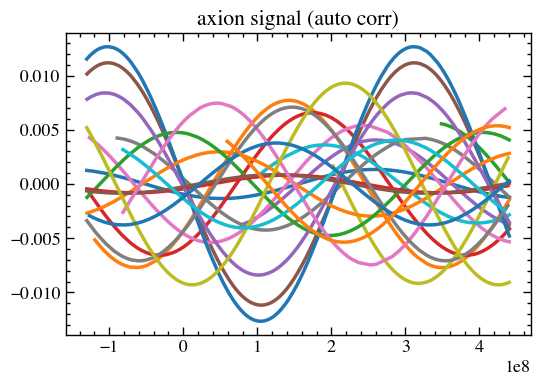

In [21]:
# white background, full signal
DPA1 = array.Gen_Mock_Data(noise_type='white',adm_signal='auto',mock_lma=-23.0 , mock_lSa=-2.5,seed=50)
DPA2 = array.Gen_Mock_Data(noise_type='white',adm_signal='none',mock_lma=-23.0 , mock_lSa=-2.5,seed=50)
for i in range(22):
    plt.plot(array.TOAs[i][0],DPA1[i][0] -DPA2[i][0] )
plt.title("axion signal (auto corr)")

Text(0.5, 1.0, 'axion signal (full corr)')

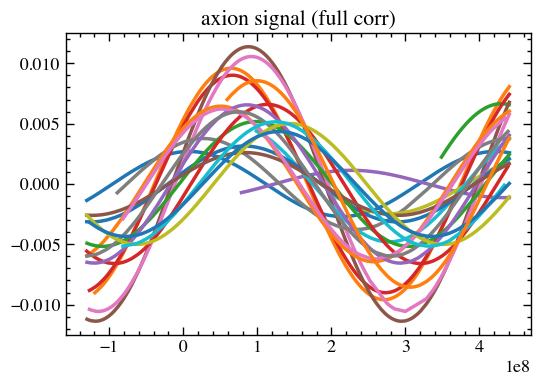

In [20]:
# white background, full signal
DPA1 = array.Gen_Mock_Data(noise_type='white',adm_signal='full',mock_lma=-23.0 , mock_lSa=-2.5,seed=50)
DPA2 = array.Gen_Mock_Data(noise_type='white',adm_signal='none',mock_lma=-23.0 , mock_lSa=-2.5,seed=50)
for i in range(22):
    plt.plot(array.TOAs[i][0],DPA1[i][0] -DPA2[i][0] )
plt.title("axion signal (full corr)")

Text(0.5, 1.0, 'red noise ')

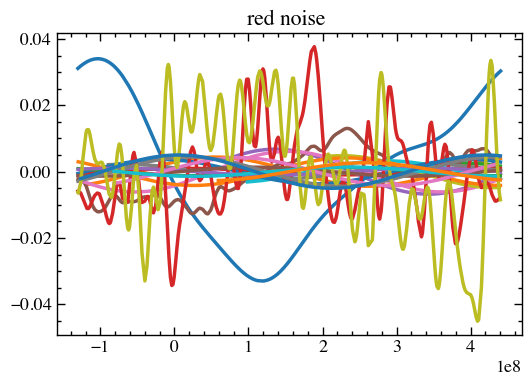

In [18]:
# another comparison
DPA1 = array.Gen_Mock_Data(noise_type='red',adm_signal='full',mock_lma=-23.0 , mock_lSa=-2.5,seed=50)
DPA2 = array.Gen_Mock_Data(noise_type='white',adm_signal='none',mock_lma=-23.0 , mock_lSa=-2.5,seed=50)
for i in range(22):
    plt.plot(array.TOAs[i][0],DPA1[i][0] -DPA2[i][0] )
plt.title("red noise ")

# This is to read chain

In [9]:
import corner
ipsr = 13
plt.figure()
plt.plot(chain[410:,-3])
chain = np.loadtxt("Signal_Chain/mock_red_se22_ana_d0_o2_r-1_isubt_10cm_nf_Np22/bin_-23.25_-23.15/chain_1.txt")
print(len(chain))
corner.corner(chain[300:,[1+ipsr,1+22+ipsr,1+22+22+ipsr , 1+22+22+22+ipsr]],show_titles=True);

NameError: name 'chain' is not defined

<Figure size 600x400 with 0 Axes>

# Test individual pulsar

In [ ]:
array1 = ppa.Array(pulsars1)
array0 = ppa.Array(pulsars)
NPSR = array0.NPSR
plt.subplots(NPSR,1,figsize=(6,5*NPSR),sharex=True,sharey=True)
for i in range(NPSR):
    plt.subplot(NPSR,1,i+1)
    plt.plot(array0.TOA[i][0] , array0.DPA[i][0],'.',label="original")
    plt.plot(array1.TOA[i][0] , array1.DPA[i][0],'.',label="ionFR subtraction")
    plt.ylim(-np.pi/4,np.pi/4)
    plt.annotate(array0.PSR_NAMES[i],xy=(0.1,0.1),xycoords="axes fraction")
    plt.xlim(-2100,5500)
    plt.legend(loc=1)
plt.savefig("ionFR.jpg",bbox_inches='tight')

NameError: name 'pulsars' is not defined

In [ ]:
pulsars1 = [ppa.Pulsar(PSR_DICT[psrn],iono="Subt",order=2,subset="10cm") for psrn in PSR_DICT]
pulsars = [ppa.Pulsar(PSR_DICT[psrn],iono="None",order=2,subset="10cm") for psrn in PSR_DICT]
array = ppa.Array(pulsars1)
test1 = array.Gen_White_Mock_Data()


lnlike = array.Generate_Lnlike_Function(method="Auto")
#lnlike( np.zeros(22+26) , np.ones(22+26)*-10 , np.ones(27) , -22,-10  )

In [ ]:
NPSR = 19
NSS = 19
groups = [np.arange(19*3+3) , [0, 2*NSS+NPSR+1 , 2*NSS+NPSR + 2  ]]

iss = 1
groups = []
for ipsr in range(NPSR):
    g = []
    nss = len( array.SUBSETS[ipsr] )
    g += np.arange(iss,iss+nss).tolist()
    g += np.arange(iss+NSS,iss+nss+NSS).tolist()
    g += [1+2*NSS+ipsr]
    iss += nss
    groups.append(g)
groups

[[1, 20, 39],
 [2, 21, 40],
 [3, 22, 41],
 [4, 23, 42],
 [5, 24, 43],
 [6, 25, 44],
 [7, 26, 45],
 [8, 27, 46],
 [9, 28, 47],
 [10, 29, 48],
 [11, 30, 49],
 [12, 31, 50],
 [13, 32, 51],
 [14, 33, 52],
 [15, 34, 53],
 [16, 35, 54],
 [17, 36, 55],
 [18, 37, 56],
 [19, 38, 57]]

In [40]:
import glob
import numpy as np
def getbf(burn = 0 , printit=True , folder="./"):
   files = sorted(glob.glob(folder+'*/chain_1.txt'))[::-1] + sorted(glob.glob(folder+"*/chain_1.0.txt"))[::-1]\
      + sorted(glob.glob(folder+'*/*/chain_1.txt'))[::-1] + sorted(glob.glob(folder+"*/*/chain_1.0.txt"))[::-1]
   res = []
   ys = []
   #l10ma = []
   np.set_printoptions(precision=3)
   for file in files:
      try:
         chain = np.loadtxt(file,skiprows=burn)
         ul = np.percentile( chain[:,-5],[5,32,50,68,95] )
         
         chain0 = chain[chain[:,0]<0]
         chain1 = chain[chain[:,0]>=0]

         if len(chain1) ==0 :
            ul1 = np.repeat(np.nan,5)
         else:
            ul1 = np.percentile(chain1[:,-5],[5,32,50,68,95])

         if len(chain0) ==0 :
            ul0 = np.repeat(np.nan,5)
         else:
            ul0 = np.percentile(chain0[:,-5],[5,32,50,68,95])

         try:
            bestfit = chain[np.argmax(chain[:,-4]),[-7,-6,-5]]
         except:
            bestfit=""

         try:
            dlnpos = chain[:,-3].max()
         except:
            dlnpos = np.nan

         y = len(chain1)/len(chain)
         ys.append(y)
         res.append([ul0.tolist(),ul1.tolist(),ul.tolist()])
         if printit == True:
            print(file.split("/")[:-1],"|",np.histogram(chain[:,0],bins=[-1,0,1])[0],
            "|%.2f"%(ul0[-1]),"%.2f"%(ul1[-1]),"|%.4f"%(y/(1-y+1e-9)),"|%.2f"%dlnpos,"|","%.1f"%np.std(chain[:,-3]))
         #l10ma.append(float(file.split("/")[0].split("_")[-1]))

      except:
         if printit==True:
            print(file.split("/")[:-1],"|")
   ys = np.array(ys)
   lbf = np.log(ys/(1-ys));lbf
   return np.array(res),lbf


def bf_thermo(burn =0):
   folders = sorted(glob.glob("*/*"))[::-1]
   allZ = []
   for folder in folders:
      files = sorted(glob.glob(folder+"/chain*.txt"))
      beta = []
      lnlmean = []
      try:
         lnlikemax = []
         for f in files:
               temp = float( f.split("/")[-1].split("_")[-1][:-4] )
               beta.append(1/temp)
               chain = np.loadtxt(f,skiprows=burn)
               lnlikemax.append(chain[:,-3].max())
               lnlmean.append(np.mean(chain[:,-3]))
         beta = np.array(beta)
         sort = np.argsort(beta)
         beta = beta[sort]
         lnlmean = np.array(lnlmean)[sort]
         Z = np.sum((lnlmean[:-1] + lnlmean[1:])*np.diff(beta))/2
         allZ.append(Z)
         print(f.split("/")[:-1],"|",len(chain[:,0]),"|%.2f|"%Z,("["+"%.1f,"*len(lnlmean))%tuple(lnlmean)+"]","|%.2f"%(max(lnlikemax)) )
      except Exception as Ex:
         print(Ex)
         print(f.split("/")[:-1])
   return np.array(allZ)


In [7]:
z0 = 14197.033215000001
z1 = np.array([14361.25719299, 14423.3956339 , 14522.92954078, 14437.17273122,
       14271.36876378]) # n f

#z1 = [14237.60,14367.25,14434.30,14531.86,14414.31]
np.array(z1)-z0

array([164.22397799, 226.3624189 , 325.89632578, 240.13951622,
        74.33554878])

14175.041795000001 14206.742175


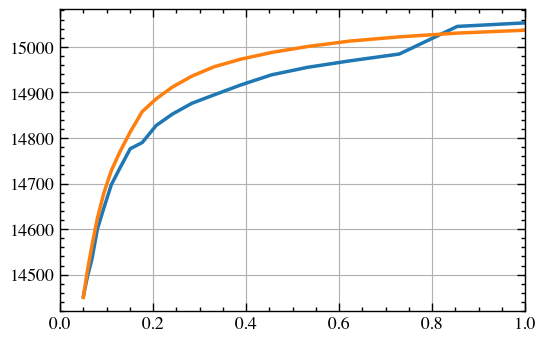

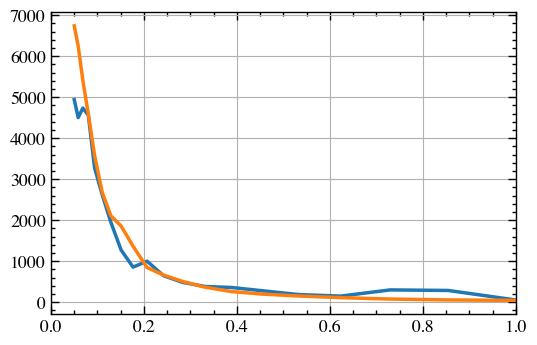

In [10]:
x = [0.0500,0.0585,0.0685,0.0802,0.0939,0.1100,0.1288,0.1508,0.1765,0.2067,0.2419,0.2833,0.3316,0.3883,0.4546,0.5322,0.6231,0.7295,0.8541,1.0000]

y1 = [14452.5,14494.5,14534.4,14600.0,14645.8,14697.1,14734.3,14776.4,14789.9,14827.5,14852.7,14876.1,14894.8,14916.3,14938.6,14955.1,14969.3,14984.3,15044.9,15052.7,]

y2 =[14450.0,14507.3,14564.0,14623.8,14678.5,14728.1,14770.0,14813.2,14857.8,14886.0,14912.1,14935.7,14956.5,14972.9,14987.7,15000.8,15012.7,15022.0,15030.2,15036.6,] 

plt.figure()
plt.xlim(0,1)
plt.grid()
plt.plot(x,y1,'-')
plt.plot(x,y2,'-')

plt.figure()
plt.xlim(0,1)
plt.grid()
plt.plot(x,np.gradient(y1,x))
plt.plot(x,np.gradient(y2,x))

print(np.trapz(y1,x),np.trapz(y2,x))